In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Loading the older catalog. 

In [3]:
pd.set_option('display.max_columns', None)
cat_all_old = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat_old = cat_all_old.copy()
cat_old

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Loading the newer catalog. 

In [4]:
pd.set_option('display.max_columns', None)
cat_all_new = pd.read_csv('../../src/IRIS_DMC_esecEventsDb_updated.txt', sep='|')
cat_new = cat_all_new.copy()
cat_new

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.07970,0.00,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
2,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
3,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
4,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.70900,0.10,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.67530,-62.17620,16.70900,-62.17620,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3500000.0,NaN,NaN,NaN,275,IRIS,NaN,2009_08_10 110853,275,1500.0,NaN,NaN,NaN,NaN,NaN,7200.0,7500.0,7000.0,23.22810,0.00,120.75170,1,NaN,NaN,NaN,NaN,NaN,208.0,True,NaN,NaN,277.0,False,NaN,NaN,NaN,"Butangbunasi, Taiwan",5,NaN,NaN,NaN,NaN,NaN,NaN,2009_08_10 110556,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",23.18310,120.77820,23.22810,120.75170,NaN,landslide,Rock/ice/debris avalanches and slides,83800000.0,NaN,NaN
315,NaN,NaN,NaN,NaN,319,"NCEDC, IRIS",NaN,2022_08_03 032337,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.39070,1.00,-122.18550,0,NaN,NaN,NaN,0.0,NaN,14.0,False,NaN,NaN,0.0,NaN,NaN,NaN,False,"Mud Creek, Mount Shasta",3,NaN,NaN,NaN,NaN,NaN,NaN,2022_08_03 012901,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
316,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,1600.0,NaN,NaN,NaN,7600.0,7900.0,7300.0,51.87130,0.00,-125.94340

## Testing the retrained models on new events

In [5]:
cat_test = cat_new.merge(
    cat_old.drop_duplicates(),        # just in case cat_old has duplicates
    how="left",
    indicator=True
).query('_merge == "left_only"') \
  .drop(columns='_merge')             # (_merge was just for filtering)



# 1️⃣  Build the sets once
ids_test = set(cat_test['eventid'])
ids_old  = set(cat_old['eventid'])

# 2️⃣  Find and display every overlapping ID
overlap = ids_test & ids_old
print(f"🔍  Overlap count: {len(overlap)}")
if overlap:
    print("Overlapping eventid(s):", sorted(overlap))

# 3️⃣  Option A – DROP the overlaps from cat_test
cat_test_clean = cat_test[~cat_test['eventid'].isin(overlap)].copy()

# ───────────────────────────────────────────────────────────────
# If you’d rather regenerate your split instead of dropping, do it
# here (e.g. re-sample from cat_new after excluding cat_old).
# ───────────────────────────────────────────────────────────────

# 4️⃣  Final safety check
assert not cat_test_clean['eventid'].isin(cat_old['eventid']).any(), \
       "Overlap still present!"

print("✅  cat_test is now disjoint from cat_old.")

cat = cat_test_clean.copy()

🔍  Overlap count: 6
Overlapping eventid(s): [4, 23, 59, 81, 166, 192]
✅  cat_test is now disjoint from cat_old.


In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [8]:
cat['starttime']

1      2017_06_23 213916
4      1997_12_26 070240
6      2013_01_21 010828
18     2020_07_24 214125
28     2021_07_27 172215
             ...        
296    2022_09_01 204553
306    2023_09_16 123545
312    2022_09_01 205421
314    2009_08_10 110556
315    2022_08_03 012901
Name: starttime, Length: 74, dtype: object

In [9]:
cat = cat.reset_index(drop = True)
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [10]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in tqdm(range(len(event_ids))):
    try:
        files = glob("../../data/iris_esec_waveforms/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

100%|██████████| 74/74 [00:07<00:00, 10.30it/s]


## Loading the trained model

## just loading the data

In [11]:
# ── 1. load every model you need ────────────────────────────────────────────
models = {
    "m2": sbm.SeismicCNN.from_pretrained("base", version_str="2"),
    "m3": sbm.SeismicCNN.from_pretrained("base", version_str="3"),
    "m5": sbm.SeismicCNN.from_pretrained("base", version_str="5"),
}

# ── 2. nested dict:  {(event, station): {model_name: probs}}
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*")

    # unique station codes in this event directory
    station_codes = {
        re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name).group(1)
        for f in file_list
        if re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name)
    }

    for stn in sorted(station_codes):
        chn_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*")

        if len(chn_list) != 3:          # need exactly Z/N/E
            continue

        try:
            st = obspy.Stream()
            for chn in chn_list:
                st += obspy.read(chn)
            st.sort(["channel"])

            # annotate with every model and store under its name
            for name, mdl in models.items():
                probs = np.asarray(mdl.annotate(st))          # (n_classes, n_windows)
                probs_global.setdefault((event_id, stn), {})[name] = probs

        except Exception as e:
            print(f"[{event_id} | {stn}] → {e}")


100%|██████████| 74/74 [01:01<00:00,  1.21it/s]


In [12]:
CLASS_IDX   = {"eq": 0, "px": 1, "noise": 2, "surface": 3}
PRIORITY    = ["eq", "px", "surface"]     # which classes can be the “winner”
MODELS_USED = ["m2", "m3", "m5"]                # adapt if you add more

def _winner_label(class_probs, thr):
    """Return label string given a dict {cls:prob}."""
    # consider only eq, px, surface for max decision
    max_cls = max(PRIORITY, key=lambda c: class_probs[c])
    return max_cls if class_probs[max_cls] > thr else "noise"

def process_probabilities(probs_dict, threshold=0.5):
    rows = []

    for (event_id, station), model_dict in probs_dict.items():
        row            = {"event_id": event_id, "station": station}
        ensemble_store = {cls: [] for cls in CLASS_IDX}   # collect per-model max

        # ── per-model columns ───────────────────────────────────────────
        for mdl_name in MODELS_USED:
            if mdl_name not in model_dict:
                continue                                  # skip missing model

            probs = model_dict[mdl_name]
            if probs.shape[0] > 4:                       # transpose if needed
                probs = probs.T

            # max over windows
            cls_max = {
                "eq"     : probs[CLASS_IDX["eq"]    ].max(),
                "px"     : probs[CLASS_IDX["px"]    ].max(),
                "noise"  : probs[CLASS_IDX["noise"] ].max(),
                "surface": probs[CLASS_IDX["surface"]].max(),
            }

            # add to row
            row[f"prob_eq_{mdl_name}"]  = cls_max["eq"]
            row[f"prob_px_{mdl_name}"]  = cls_max["px"]
            row[f"max_prob_{mdl_name}"] = max(cls_max[c] for c in PRIORITY)
            row[f"assigned_label_{mdl_name}"] = _winner_label(cls_max, threshold)

            # accumulate for ensemble
            for cls, val in cls_max.items():
                ensemble_store[cls].append(val)

        # ── ensemble mean columns ───────────────────────────────────────
        ens_mean = {cls: float(np.mean(vals)) for cls, vals in ensemble_store.items()}
        row["prob_eq_ens"]     = ens_mean["eq"]
        row["prob_px_ens"]     = ens_mean["px"]
        row["prob_noise_ens"]  = ens_mean["noise"]
        row["prob_surface_ens"]= ens_mean["surface"]
        row["max_prob_ens"]    = max(ens_mean[c] for c in PRIORITY)
        row["assigned_label_ens"] = _winner_label(ens_mean, threshold)

        rows.append(row)

    return pd.DataFrame(rows)


In [13]:
labels_df = process_probabilities(probs_global, threshold = 0.5)

In [14]:
labels_df

,event_id,station,prob_eq_m2,prob_px_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,max_prob_m3,assigned_label_m3,prob_eq_m5,prob_px_m5,max_prob_m5,assigned_label_m5,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens
0,276,BABIT,0.000874,0.004738,0.994252,surface,0.079196,0.878632,0.878632,px,0.160078,0.156019,0.705073,surface,0.080049,0.346463,0.972730,0.683562,0.683562,surface
1,276,BARN,0.133080,0.003457,0.133080,noise,0.426349,0.498116,0.987628,surface,0.935541,0.007220,0.935541,eq,0.498323,0.169598,0.990238,0.388400,0.498323,noise
2,276,LG2B,0.683013,0.018244,0.864213,surface,0.991481,0.630306,0.991481,eq,0.999495,0.077302,0.999495,eq,0.891330,0.241951,0.969312,0.400032,0.891330,eq
3,276,PRCT,0.854343,0.108253,0.854343,eq,0.948478,0.118815,0.948478,eq,0.998076,0.979118,0.998076,eq,0.933632,0.402062,0.876299,0.121990,0.933632,eq
4,276,U15A,0.000100,0.000322,0.000322,noise,0.000004,0.000037,0.000091,noise,0.000127,0.000420,0.000470,noise,0.000077,0.000260,0.999998,0.000253,0.000260,noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,297,VOIT,0.000120,0.000729,0.000729,noise,0.000031,0.007896,0.007896,noise,0.000049,0.074455,0.074455,noise,0.000067,0.027693,0.999956,0.000103,0.027693,noise
1136,297,WIKI,0.000006,0.000027,0.000027,noise,0.000316,0.003116,0.003116,noise,0.002078,0.000004,0.009241,noise,0.000800,0.001049,1.000000,0.003769,0.003769,noise
1137,297,YOCR,0.003724,0.011644,0.901054,surface,0.000641,0.002873,0.691773,surface,0.000350,0.016027,0.996011,surface,0.001571,0.010181,0.999997,0.862946,0.862946,surface
1138,319,SALT,0.004407,0.000568,0.004407,noise,0.001465,0.047557,0.047557,noise,0.000934,0.000392,0.000934,noise,0.002269,0.016172,0.999997,0.006563,0.016172,noise


In [15]:
labels_df

,event_id,station,prob_eq_m2,prob_px_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,max_prob_m3,assigned_label_m3,prob_eq_m5,prob_px_m5,max_prob_m5,assigned_label_m5,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens
0,276,BABIT,0.000874,0.004738,0.994252,surface,0.079196,0.878632,0.878632,px,0.160078,0.156019,0.705073,surface,0.080049,0.346463,0.972730,0.683562,0.683562,surface
1,276,BARN,0.133080,0.003457,0.133080,noise,0.426349,0.498116,0.987628,surface,0.935541,0.007220,0.935541,eq,0.498323,0.169598,0.990238,0.388400,0.498323,noise
2,276,LG2B,0.683013,0.018244,0.864213,surface,0.991481,0.630306,0.991481,eq,0.999495,0.077302,0.999495,eq,0.891330,0.241951,0.969312,0.400032,0.891330,eq
3,276,PRCT,0.854343,0.108253,0.854343,eq,0.948478,0.118815,0.948478,eq,0.998076,0.979118,0.998076,eq,0.933632,0.402062,0.876299,0.121990,0.933632,eq
4,276,U15A,0.000100,0.000322,0.000322,noise,0.000004,0.000037,0.000091,noise,0.000127,0.000420,0.000470,noise,0.000077,0.000260,0.999998,0.000253,0.000260,noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,297,VOIT,0.000120,0.000729,0.000729,noise,0.000031,0.007896,0.007896,noise,0.000049,0.074455,0.074455,noise,0.000067,0.027693,0.999956,0.000103,0.027693,noise
1136,297,WIKI,0.000006,0.000027,0.000027,noise,0.000316,0.003116,0.003116,noise,0.002078,0.000004,0.009241,noise,0.000800,0.001049,1.000000,0.003769,0.003769,noise
1137,297,YOCR,0.003724,0.011644,0.901054,surface,0.000641,0.002873,0.691773,surface,0.000350,0.016027,0.996011,surface,0.001571,0.010181,0.999997,0.862946,0.862946,surface
1138,319,SALT,0.004407,0.000568,0.004407,noise,0.001465,0.047557,0.047557,noise,0.000934,0.000392,0.000934,noise,0.002269,0.016172,0.999997,0.006563,0.016172,noise


In [16]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()
print(len(labels_df))

1140


In [17]:
labels_df.to_csv('../seisbench_output/esec_event_output_labels_from_retrained_model.csv')

In [18]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
#for i in tqdm(range(100, 150)):    
    event_id = labels_df['event_id'].values[i]
    station = labels_df['station'].values[i]
    files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HN*')
    tr = obspy.read(files[0])
    tr.resample(50)
    tr.detrend('linear')
    tr.taper(0.05)
    tr.filter('bandpass', freqmin = 1, freqmax = 20)

    #plot_trace(tr)
    #print(label)
    # snr - signal to noise ratio
    d = tr[0].data
    
    #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
    #print(snr)
    
    snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    
labels_df['snr_n'] = snr

100%|██████████| 1140/1140 [00:07<00:00, 156.80it/s]


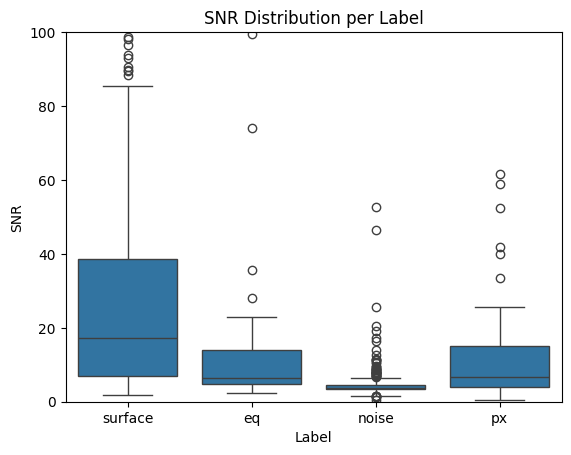

In [19]:
sns.boxplot(data=labels_df, x="assigned_label_m5", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,100)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


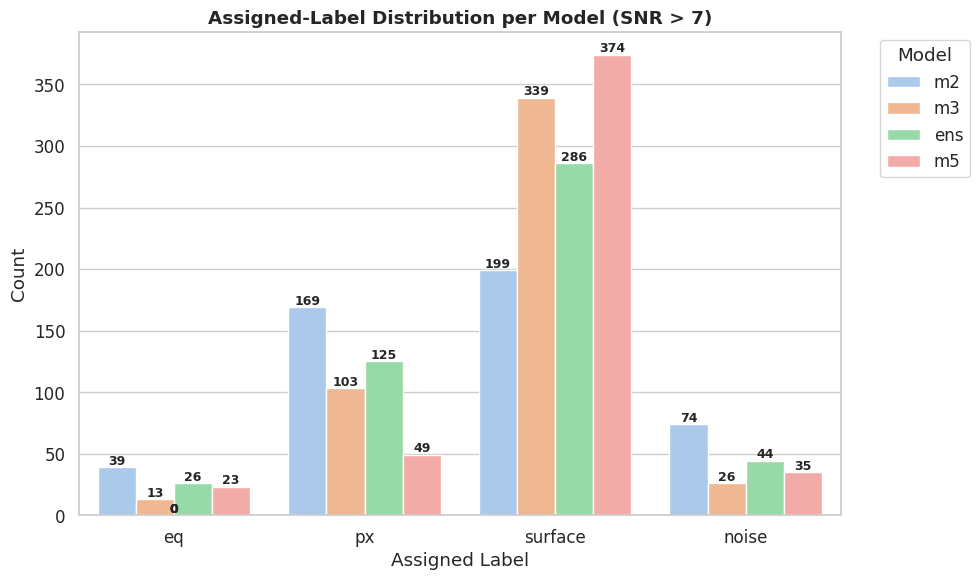

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------
# 1.  Select the model-label columns you want to compare
# ------------------------------------------------------------------
model_cols = [
    "assigned_label_m2",
    "assigned_label_m3",
    "assigned_label_ens",   # ensemble-mean
    "assigned_label_m5",    # add/remove as needed
]

# ------------------------------------------------------------------
# 2.  Filter rows (SNR > 7) and reshape to long form
# ------------------------------------------------------------------
filtered = labels_df[labels_df["snr_n"] > 7].copy()

long_df = filtered.melt(
    value_vars=model_cols,
    var_name="model",
    value_name="assigned_label"
)

# Clean model names for nicer legend labels
long_df["model"] = (
    long_df["model"]
    .str.replace("assigned_label_", "", regex=False)  # m2 → m2, ens → ens
)

# Establish a consistent label order (eq / px / surface / noise)
label_order = ["eq", "px", "surface", "noise"]

# ------------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=long_df,
    x="assigned_label",
    hue="model",
    order=label_order,
    palette="pastel"
)

# ------------------------------------------------------------------
# 4.  Annotate bar heights
# ------------------------------------------------------------------
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# ------------------------------------------------------------------
# 5.  Cosmetics
# ------------------------------------------------------------------
plt.title("Assigned-Label Distribution per Model (SNR > 7)", weight="bold")
plt.xlabel("Assigned Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [31]:
good_df  = labels_df[labels_df['snr_n'] > 7]
mean_probs = good_df.groupby('event_id')[['prob_eq', 'prob_px', 'prob_surface']].mean()

# Step 2: Identify the label with the highest mean probability (excluding noise)
mean_probs['event_label'] = mean_probs.idxmax(axis=1).str.replace('prob_', '')

# Optional: merge back into original DataFrame if needed
good_df = good_df.merge(mean_probs['event_label'], on='event_id', how='left')

/tmp/ipykernel_3888832/1556354953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mean_probs, x='event_label', palette='Set2')


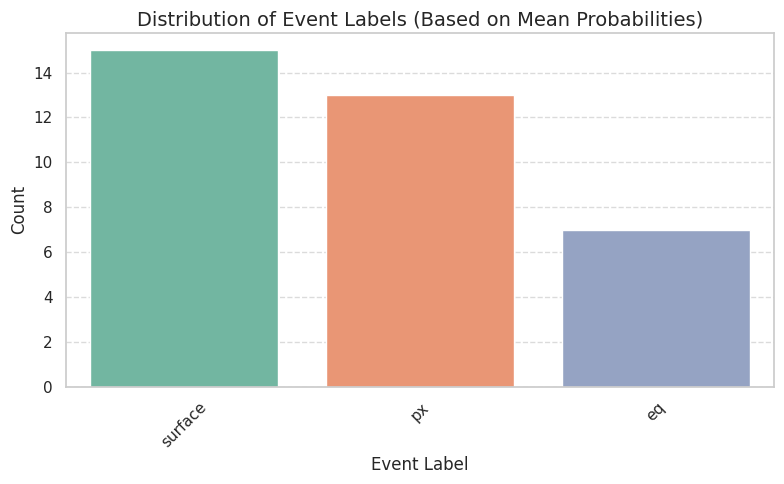

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(data=mean_probs, x='event_label', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [33]:
good_df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
0,276,PRCT,8.543427e-01,0.108253,0.992975,0.039274,0.854343,eq,12.516802,eq
1,276,U15A,1.003786e-04,0.000322,0.999996,0.000197,0.000322,noise,8.077343,eq
2,302,CERA,1.921099e-07,0.000001,0.999999,0.000006,0.000006,noise,7.659795,surface
3,302,IOCA,5.063355e-03,0.023275,0.955110,0.995776,0.995776,surface,61.584441,surface
4,302,OT11,2.509664e-01,0.042083,0.999997,0.621105,0.621105,surface,7.143614,surface
...,...,...,...,...,...,...,...,...,...,...
476,297,BOIS,9.270422e-02,0.731575,0.962852,0.165847,0.731575,px,10.218303,eq
477,297,KUHN,9.997645e-01,0.812830,0.999990,0.008474,0.999765,eq,23.656638,eq
478,297,MONKS,9.548517e-01,0.498697,0.981633,0.356169,0.954852,eq,16.492661,eq
479,297,NBFR,6.577789e-01,0.979918,0.990219,0.009419,0.979918,px,99.412314,eq


In [28]:
def plot_event_waveforms(event_id, labels_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/'):
    # Filter rows for this event
    subset = labels_df[labels_df['event_id'] == event_id]
    
    event_type = cat[cat['eventid'] == event_id]['type'].values[0]
    if subset.empty:
        print(f"No data found for event {event_id}")
        return
    
    # Get event-level label from the first row
    event_label = subset['event_label'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 1.8 * len(subset)))
    
    for idx, row in subset.iterrows():
        station = row['station']
        
        # Find the vertical-component HZ file
        files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HZ*')
        if not files:
            print(f"No HZ component found for {station} in event {event_id}")
            continue
        
        try:
            tr = obspy.read(files[0])[0]
            tr.resample(50)
            tr.detrend('linear')
            tr.taper(0.05)
            tr.filter('bandpass', freqmin=1, freqmax=20)
            data = tr.data
            times = np.arange(len(data)) / tr.stats.sampling_rate

            # Offset the waveform vertically
            offset = idx
            ax.plot(times, data / np.max(np.abs(data)) + offset, lw=0.8, color='steelblue')

            # Format the label with probabilities
            prob_text = f"{station} | eq:{row['prob_eq']:.2f} px:{row['prob_px']:.2f} su:{row['prob_surface']:.2f}"
            ax.text(times[-1] + 2, offset, prob_text, va='center', fontsize=8)

        except Exception as e:
            print(f"Error loading {station} for event {event_id}: {e}")
            continue
    
    ax.set_title(f"Event {event_id} | Label: {event_label.upper()} | Event Type: {event_type}", fontsize=14, weight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])  # Remove numerical ticks; we use text annotations
    ax.set_ylabel("Stations (vertical offset)")
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Ensure save directory exists
    os.makedirs(savepath, exist_ok=True)
    # Now save
    plt.savefig(os.path.join(savepath, f'{event_id}_from_retrained.png'))
    
    plt.close()

In [29]:
eq_df = mean_probs[mean_probs['event_label'] == 'eq']
px_df = mean_probs[mean_probs['event_label'] == 'px']
su_df = mean_probs[mean_probs['event_label'] == 'surface']

In [30]:
event_ids = eq_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/')

    
event_ids = px_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/explosion/')

    
event_ids = su_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/surface/')